<center>

*******************************************************************************************
<font size="4">
Rank-correlation between annotated and computed synchronisation &nbsp; &nbsp; <br>
with multiple combinations of  paramaters
</font>

##### 4 November 2025

##### Juan Ignacio Mendoza Garay

*******************************************************************************************

</center>

##### INFORMATION:

* This program demonstrates the `multicombo` function, which runs a data pipeline with multiple combinations of parameters.
* The program is evaluated using synchronisation measure Kuramoto Order Parameter *r*. The resulting syncrhonisation scores are correlated with annotated ground-truth synchronisation scores.
>
* Tested with:
    * Python 3.11
    * Windows 11
>
* Instructions:
    * Edit the values indicated with an arrow like this: <---

*******************************************************************************************

In [1]:
import sys

import numpy as np
from IPython.display import display, HTML

sc_path = '../../src'
sys.path.append(sc_path)
import syncoord as sc

***
### Declare paths and parameters

In [2]:
extfunc_path = 'C:/MyTemp/Matlab'  # <--- folder with external Matlab functions
gxwt_path = sc_path                # <--- folder with gxwt Matlab function
# Matlab functions only for GXWT. If GXWT won't be used, these variables won't be used either.

results_folder = '' # <--- results' folder

***
### Generate synthetic data

#### Signals

index; key; Name; duration (s):
  0; 0; Test Data; 0:16.0


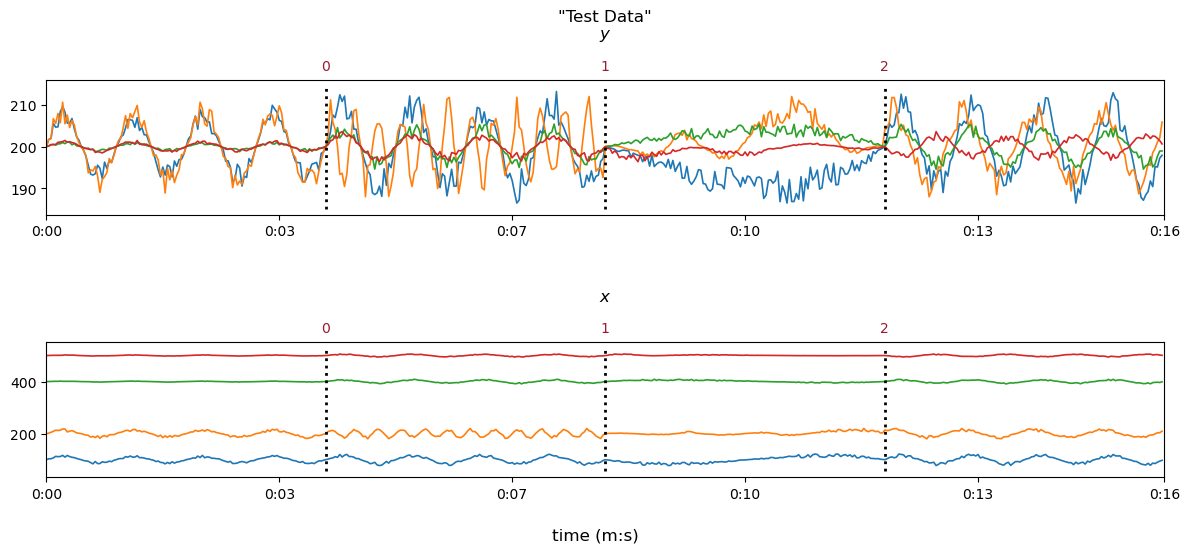

In [3]:
base_freq = 1     # <--- baseline frequency (Hz)
shuffseed = None  # <--- None = don't shuffle sections, int = shuffle sections
noise_fac = 0.5   # <--- noise strength for sections 0, 1, 3

testdata_vars = sc.utils.init_testdatavars(seed=1)
testdata_vars['point_vars'][[0,1,3],...,0] = base_freq
testdata_vars['point_vars'][1,1,...,0] = base_freq * 3
testdata_vars['point_vars'][...,5] = noise_fac
testdata_vars['point_vars'][2,...,5] = 0.5 # noise strength for section 2
if shuffseed is not None:
    rangen = np.random.default_rng(seed=shuffseed)
    rangen.shuffle(testdata_vars['point_vars'])
test_data_1 = sc.ptdata.load( testdata_vars, print_info=True )
test_data_1.visualise( vscale=1.2, dlattr='1.2' )

Unshuffled sections:
>0. All synchronised at baseline frequency, but signals 0 and 1 have higher amplitude.
>1. As in section 0, but signal 1 has triple the baseline frequency.
>2. Random oscillation.
>3. All have baseline frequency, but with constant phase differences: 1/8 cycle for signals 0 and 1; 1/2 cycle (*out of phase*) for signals 2 and 3.

Also each signal has distinct random noise.

#### Annotated synchronisation rank

In [4]:
sel_annot_sync = (3, 2, 0, 1)
sel_annot_lbl = 'annot. sync 1'

***
## Combinations of Parameters

>
### Pipeline parameters and values
Parameters include synchronisation method, and the free variables for each process.

In [5]:
itpar = {} # iteration values

# values common to more than one step:
foi = [base_freq, 2*base_freq]
foi_fft = foi + [[1,10]]             # <--- frequencies of interest for FFT (Hz)
# foi_cwt = foi + [[0.1,2]]            # <--- frequencies of interest for CWT (Hz)
ws = [1/(2*base_freq), 1/base_freq]  # <--- window size (s)

# Reduce to 1 dimension per point with filtering option ............................................

itpar[('filtred','main')] = 'method'
itpar[('filtred','method')] = ['norms','speed','x']  # <--- 'norms', 'speed', 'x', 'y', 'z'

itpar[('filtred','spec','norms','dim')] = 2          # <--- dimensions (only for 'norms' or 'speed')
itpar[('filtred','spec','speed','dim')] = 2          # <--- dimensions (only for 'norms' or 'speed')
itpar[('filtred','spec','speed','filter_type')] = ['savgol']  # <--- 'savgol', 'butter', 'none'
itpar[('filtred','spec','speed','window_size')] = ws          # <--- if 'savgol': window size (s)
itpar[('filtred','spec','speed','order')] = [1, 2, 3]         # <--- filter's order

# Phase ............................................................................................

itpar[('phase','main')] = 'method'
itpar[('phase','method')] = ['FFT']                 # <--- 'peaks', 'FFT'

# itpar[('phase','spec','peaks','min_dist')] = [base_freq/2, base_freq]  # <--- peaks' min. dist. (s)
itpar[('phase','spec','FFT','fft_freq')] = foi_fft  # <--- FFT frequency orfrequencies (Hz)

# Synchronisation ..................................................................................

itpar[('sync','main')] = 'method'
itpar[('sync','method')] = ['r']                      # <--- 'r', PLV', 'WCT', 'GXWT'

# itpar[('sync','spec','PLV','windows')] = ws + ['sections']  # <--- PLV windows (s. or 'sections')
# itpar[('sync','spec','WCT','cwt_freq')] = foi_cwt   # <--- CWT frequency or frequencies (Hz)
# itpar[('sync','spec','GXWT','cwt_freq')] = foi_cwt  # <--- CWT frequency or frequencies (Hz)

# Statistics .......................................................................................

itpar[('stats','main')] = 'func'
itpar[('stats','func')] = [('secstats','corr')]  # <--- 'secstats', 'corr', or both in tuple

# itpar[('stats','func')] = [('secstats','corr'),'corr']  # <--- 'secstats', 'corr', or both in tuple
itpar[('stats','spec',('secstats','corr'))] = ''  # only to map the record labels
# itpar[('stats','spec','corr','cont')] = True  # <--- continuous result, for 'secstats' or 'corr'

itpar[('stats','arr')] = sel_annot_sync       # <--- if 'corr': arrays to correlate sync with
itpar[('stats','arrlbl')] = sel_annot_lbl     # <--- if 'corr': array labels

>
#### Record labels
Names for parameters and results that shall be recorded.

In [6]:
rlbl = {}
rlbl[('sync','method')] = 'sync method'
# rlbl[('stats','spec','corr','cont')] = ['tau cont','p cont']
rlbl[('stats','spec',('secstats','corr'))] = ['tau means','p means']
rlbl[('filtred','spec','speed','filter_type')] = 'filt. type'
rlbl[('filtred','spec','speed','window_size')] = 'filt. win.'
rlbl[('filtred','spec','speed','order')] = 'filt. ord.'
rlbl[('filtred','method')] = 'dim. red. method'
# rlbl[('phase','method')] = 'phase method'
# rlbl[('phase','spec','peaks','min_dist')] = 'pk. min. dist.'
rlbl[('phase','spec','FFT','fft_freq')] = 'freq. of int.'
# rlbl[('sync','spec','PLV','windows')] = 'PLV window'
# rlbl[('sync','spec','WCT','cwt_freq')] = 'freq. of int.'
# rlbl[('sync','spec','GXWT','cwt_freq')] = 'freq. of int.'


>
### Run pipeline for all combinations

In [7]:
mckwargs = { 'matlab' : [extfunc_path, gxwt_path],
             'itpar' : itpar,
             'rlbl' : rlbl,
             'results_folder' : results_folder,
             'max_newres' : None, # <--- Maximum number of new results. Useful for testing
             'verbose' : 1 }      # <--- 0 = none, 1 = final, 2 = running

n_display = None # <--- int, 'all', or None

all_results_df = sc.multicombo(test_data_1, **mckwargs)
if n_display == 'all': display(HTML(all_results_df.to_html()))
elif isinstance(n_display,int): display(HTML(all_results_df.iloc[:n_display].to_html()))

computation time = 0:00:00.005
Total number of results = 24


***
## Results sorted by correlation scores

In [8]:
all_results_df.sort_values('tau means', ascending=False)

,sync method,tau means,p means,filt. type,filt. win.,filt. ord.,dim. red. method,freq. of int.
i,,,,,,,,
0,r,1.000000,0.083333,-,-,-,norms,1.0
1,r,1.000000,0.083333,-,-,-,norms,2.0
2,r,1.000000,0.083333,-,-,-,norms,"[1, 10]"
5,r,1.000000,0.083333,savgol,0.5,1.0,speed,"[1, 10]"
7,r,1.000000,0.083333,savgol,0.5,2.0,speed,2.0
13,r,1.000000,0.083333,savgol,1.0,1.0,speed,2.0
10,r,1.000000,0.083333,savgol,0.5,3.0,speed,2.0
11,r,1.000000,0.083333,savgol,0.5,3.0,speed,"[1, 10]"
23,r,1.000000,0.083333,-,-,-,x,"[1, 10]"
